In [4]:
import pandas as pd

data = pd.read_csv("/Users/andyyang/Downloads/Currency/exchange_rate_data.csv")

print(data)

     CNY (China)  INR (India)  RUB (Russia)  JPY (Japan)  Euro (EU)  \
0         7.2794       39.170       24.4390       109.89    0.67921   
1         7.2660       39.210       24.4480       109.40    0.67972   
2         7.2431       39.340       24.3700       107.20    0.67622   
3         7.2291       39.235       24.6620       106.44    0.68568   
4         7.1910       39.605       24.4520       106.69    0.67481   
..           ...          ...           ...          ...        ...   
869       7.1130       83.910       90.6455       146.97    0.90408   
870       7.1166       83.950       90.3455       143.56    0.90555   
871       7.0963       83.860       89.9955       139.91    0.89880   
872       7.0544       83.550       92.3505       143.52    0.89936   
873       7.1131       84.070       94.3205       150.00    0.92140   

     BRZ (Brazil)  IDR (Indonesia)  GBP (Great Britain)  
0          1.7591             9410              0.50511  
1          1.7618             9

In [5]:
from datetime import datetime, timedelta

# Function to generate weekly timestamps
def generate_weekly_timestamps(start_date, end_date):
    """
    Generates weekly timestamps between start_date and end_date.

    :param start_date: The start date as a string in "YYYY-MM-DD" format
    :param end_date: The end date as a string in "YYYY-MM-DD" format
    :return: List of weekly timestamps
    """
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Generate timestamps
    weekly_timestamps = []
    while start <= end:
        weekly_timestamps.append(start.strftime("%Y-%m-%d"))
        start += timedelta(weeks=1)
    
    return weekly_timestamps

# Example usage
start_date = "2007-12-31"
end_date = "2040-12-31"
timestamps = generate_weekly_timestamps(start_date, end_date)


In [6]:
data_inr = pd.DataFrame({"Time": timestamps[0:874], "Data": data.iloc[:, 1]})

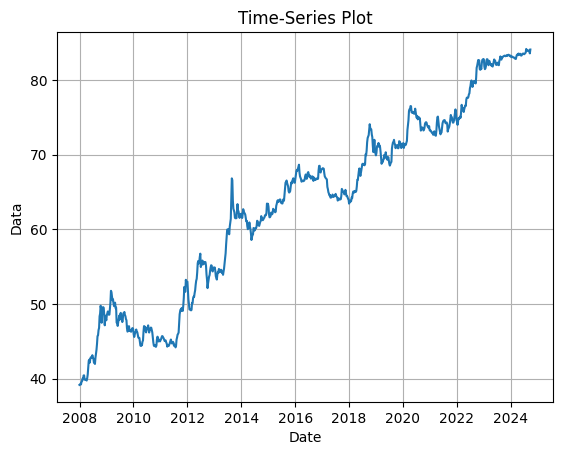

In [7]:
import matplotlib.pyplot as plt

# Ensure the date format matches the data
data_inr['DateTime'] = pd.to_datetime(data_inr['Time'], format='%Y-%m-%d')

# Set the DateTime column as the index
data_inr.set_index('DateTime', inplace=True)

# Plot the data
plt.plot(data_inr.index, data_inr['Data'])
plt.xlabel("Date")
plt.ylabel("Data")
plt.title("Time-Series Plot")
plt.grid()
plt.show()


In [8]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure the 'Data' column is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Filter training and testing data based on the date
train_data = data_inr[data_inr.index < '2022-01-01']
test_data = data_inr[data_cny.index >= '2022-01-01']

# Scale the training data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Data']].values)

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' steps)
        y.append(data[i, 0])          # Target (next value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 30
X_train, y_train = create_sequences(scaled_train_data, window)

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dropout(0.3),  # Dropout after the second LSTM layer
    Dense(32, activation='relu'),  # Fully connected dense layer
    Dense(1)  # Output layer (1 value for the next step)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Scale the testing data
scaled_test_data = scaler.transform(test_data[['Data']].values)

# Create sequences for the testing data
X_test, y_test = create_sequences(scaled_test_data, window)

# Reshape the testing data for LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict the testing data
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse scale the predictions and actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Validation Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[window:], y_test_actual, label='Actual Data', color='blue')
plt.plot(test_data.index[window:], y_pred_actual, label='Predicted Data', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('LSTM Validation Results (Data from 2023)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'data_cny' is not defined

In [1]:
# Forecast for the next 300 steps
# Use the last 'window' data points as input for forecasting
inputs = scaler.transform(data_inr[['Data']].values[-window:]).reshape((1, window, 1))
forecast_scaled = []

# Generate rolling forecast for 300 steps
for _ in range(100):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next value
    forecast_scaled.append(pred)
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input sequence
    inputs[0, -1, 0] = pred  # Replace the last value in the sequence with the prediction

# Inverse scale the forecasted values back to the original scale
forecast_100 = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create a forecast index for the next 300 steps
forecast_index_100 = pd.date_range(start=data_inr.index[-1], periods=100, freq="W")

# Filter original data to include only data from 2022 onward
data_from_2022 = data_inr[data_inr.index >= '2022-01-01']

# Create a combined dataset for the forecast (next 100 steps)
forecast_index = pd.date_range(start=data_inr.index[-1], periods=100, freq="D")
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Data': forecast_100.flatten()
}).set_index('Date')

# Plot the original data, validation data (actual vs predicted), and forecast
plt.figure(figsize=(14, 7))

# Plot the actual data from 2022 onward
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')

# Plot the validation data (actual vs. predicted from 2023 onward)
plt.plot(test_data.index[window:], y_test_actual, label='Validation Actual Data (From 2023)', color='green')
plt.plot(test_data.index[window:], y_pred_actual, label='Validation Predicted Data (From 2023)', linestyle='--', color='orange')

# Plot the forecast for the next 100 steps
plt.plot(forecast_df.index, forecast_df['Forecasted Data'], label='Forecast (Next 100 Steps)', linestyle='--', color='red')

# Add plot details
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Data from 2022 Onward with Validation and Forecast (100 Steps)')
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'scaler' is not defined

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29976D-01    |proj g|=  5.72475D-01


 This problem is unconstrained.



At iterate    5    f=  7.51480D-01    |proj g|=  7.65448D-02

At iterate   10    f=  7.07853D-01    |proj g|=  9.43880D-03

At iterate   15    f=  7.05912D-01    |proj g|=  1.22980D-02

At iterate   20    f=  7.05737D-01    |proj g|=  9.13971D-03

At iterate   25    f=  7.05666D-01    |proj g|=  1.55709D-03

At iterate   30    f=  7.05655D-01    |proj g|=  3.14537D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     53      1     0     0   2.918D-04   7.057D-01
  F =  0.70565300326357205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Epoch 1/50


/var/folders/ym/q8pn40b973g61znsnb_4mfvc0000gn/T/ipykernel_13167/2610418449.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Trend_Seasonality'] = sarima_fit.fittedvalues
/var/folders/ym/q8pn40b973g61znsnb_4mfvc0000gn/T/ipykernel_13167/2610418449.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Trend_Seasonality'] = sarima_fit.get_forecast(steps=len(test_data)).predicted_mean.values
/var/folders/ym/q8pn40b973g61znsnb_4mfvc0000gn/T/ipykernel_13167/2610418449.py:27: SettingWithC

22/22 - 2s - 81ms/step - loss: 0.0332 - val_loss: 3.9412e-04 - learning_rate: 0.0010
Epoch 2/50
22/22 - 0s - 6ms/step - loss: 0.0031 - val_loss: 3.7585e-04 - learning_rate: 0.0010
Epoch 3/50
22/22 - 0s - 7ms/step - loss: 0.0015 - val_loss: 1.6961e-04 - learning_rate: 0.0010
Epoch 4/50
22/22 - 0s - 7ms/step - loss: 0.0014 - val_loss: 9.8237e-05 - learning_rate: 0.0010
Epoch 5/50
22/22 - 0s - 7ms/step - loss: 0.0010 - val_loss: 6.6200e-05 - learning_rate: 0.0010
Epoch 6/50
22/22 - 0s - 7ms/step - loss: 8.9862e-04 - val_loss: 6.2590e-05 - learning_rate: 0.0010
Epoch 7/50
22/22 - 0s - 7ms/step - loss: 8.9635e-04 - val_loss: 5.9823e-05 - learning_rate: 0.0010
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 - 0s - 7ms/step - loss: 8.1903e-04 - val_loss: 8.6701e-05 - learning_rate: 0.0010
Epoch 9/50
22/22 - 0s - 7ms/step - loss: 7.2888e-04 - val_loss: 1.2045e-04 - learning_rate: 5.0000e-04
Epoch 10/50
22/22 - 0s - 7ms/step - loss: 7.5462e-04 - val

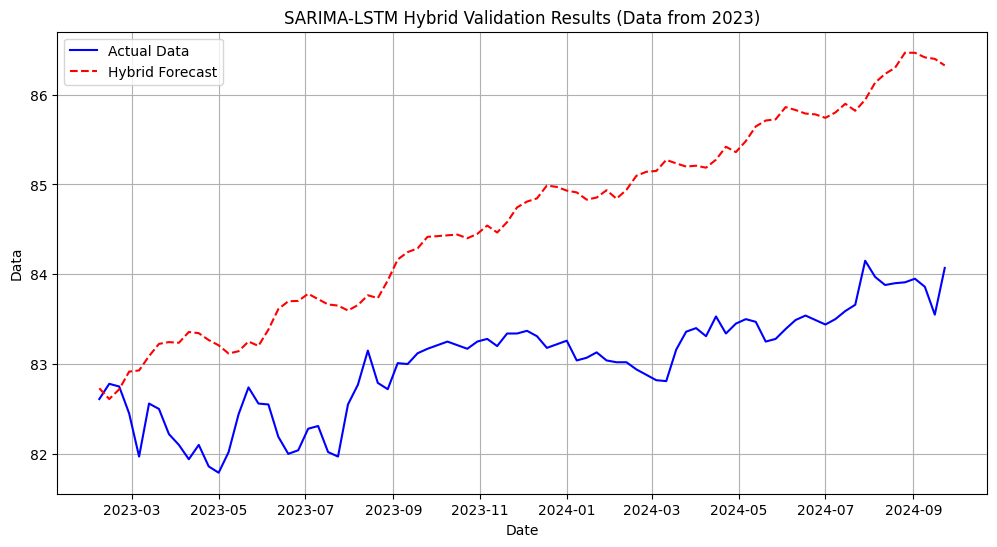

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure the 'Data' column is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Filter training and testing data based on the date
train_data = data_inr[data_inr.index < '2023-01-01']
test_data = data_inr[data_inr.index >= '2023-01-01']

# Fit SARIMA model on the training data
sarima_model = SARIMAX(train_data['Data'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Predict trend/seasonality for training and testing sets
train_data['Trend_Seasonality'] = sarima_fit.fittedvalues
test_data['Trend_Seasonality'] = sarima_fit.get_forecast(steps=len(test_data)).predicted_mean.values

# Compute residuals
train_data['Residual'] = train_data['Data'] - train_data['Trend_Seasonality']
test_data['Residual'] = test_data['Data'] - test_data['Trend_Seasonality']

# Scale the residuals
scaler = MinMaxScaler()
scaled_train_residuals = scaler.fit_transform(train_data[['Residual']].dropna())
scaled_test_residuals = scaler.transform(test_data[['Residual']].dropna())

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' residuals)
        y.append(data[i, 0])          # Target (next residual value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 5
X_train, y_train = create_sequences(scaled_train_residuals, window)
X_test, y_test = create_sequences(scaled_test_residuals, window)

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dropout(0.3),  # Dropout after the second LSTM layer
    Dense(32, activation='relu'),  # Fully connected dense layer
    Dense(1)  # Output layer (1 value for the next step)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train the LSTM model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Forecast residuals for the testing period using the LSTM model
forecast_scaled_residuals = model.predict(X_test, verbose=0)

# Inverse scale the forecasted residuals back to the original scale
forecast_residuals = scaler.inverse_transform(forecast_scaled_residuals)

# Combine SARIMA trend/seasonality forecast with LSTM residual forecast
final_forecast = test_data['Trend_Seasonality'].iloc[window:].values + forecast_residuals.flatten()

# Evaluate the hybrid model's performance
y_test_actual = test_data['Data'].iloc[window:].values
mae = mean_absolute_error(y_test_actual, final_forecast)
mse = mean_squared_error(y_test_actual, final_forecast)
rmse = np.sqrt(mse)

print(f"Validation Results (SARIMA-LSTM Hybrid Model):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[window:], y_test_actual, label='Actual Data', color='blue')
plt.plot(test_data.index[window:], final_forecast, label='Hybrid Forecast', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('SARIMA-LSTM Hybrid Validation Results (Data from 2023)')
plt.legend()
plt.grid(True)
plt.show()


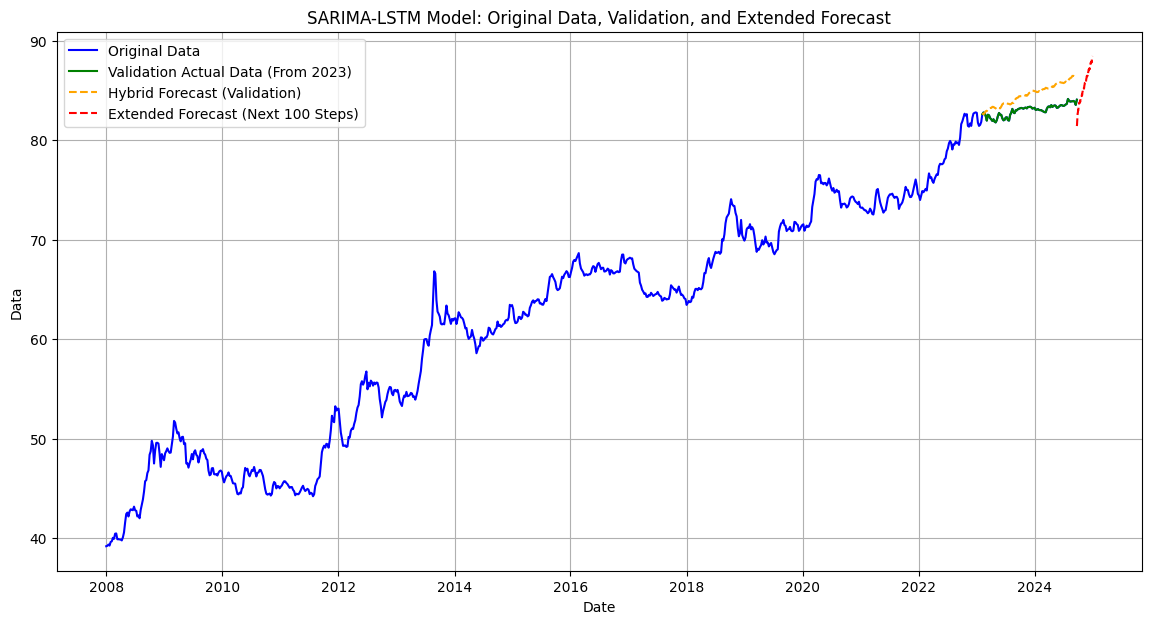

In [10]:
# Extend the hybrid model forecast for 100 additional steps beyond the testing period

# Use the last 'window' residuals from the test set as input for forecasting
inputs = scaled_test_residuals[-window:].reshape((1, window, 1))
extended_forecast_scaled_residuals = []

# Generate rolling forecast for the next 100 steps
for _ in range(100):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next residual
    extended_forecast_scaled_residuals.append(pred)
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input sequence
    inputs[0, -1, 0] = pred  # Replace the last value in the sequence with the prediction

# Inverse scale the extended residual forecast back to the original scale
extended_forecast_residuals = scaler.inverse_transform(np.array(extended_forecast_scaled_residuals).reshape(-1, 1))

# Forecast trend/seasonality for the next 100 steps using SARIMA
sarima_extended_trend = sarima_fit.get_forecast(steps=100).predicted_mean.values

# Combine the SARIMA trend/seasonality and LSTM residuals for the final forecast
extended_final_forecast = sarima_extended_trend + extended_forecast_residuals.flatten()

# Create a forecast index for the next 100 steps
forecast_index = pd.date_range(start=test_data.index[-1], periods=100, freq="W")

# Plot the original data, verification data, and extended forecast
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')

# Plot the actual data from the test set
plt.plot(test_data.index[window:], y_test_actual, label='Validation Actual Data (From 2023)', color='green')

# Plot the hybrid model's validation results (SARIMA + LSTM)
plt.plot(test_data.index[window:], final_forecast, label='Hybrid Forecast (Validation)', linestyle='--', color='orange')

# Plot the extended forecast for the next 100 steps
plt.plot(forecast_index, extended_final_forecast, label='Extended Forecast (Next 100 Steps)', linestyle='--', color='red')

# Add plot details
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('SARIMA-LSTM Model: Original Data, Validation, and Extended Forecast')
plt.legend()
plt.grid(True)
plt.show()


16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:30 - cmdstanpy - INFO - Chain [1] done processing


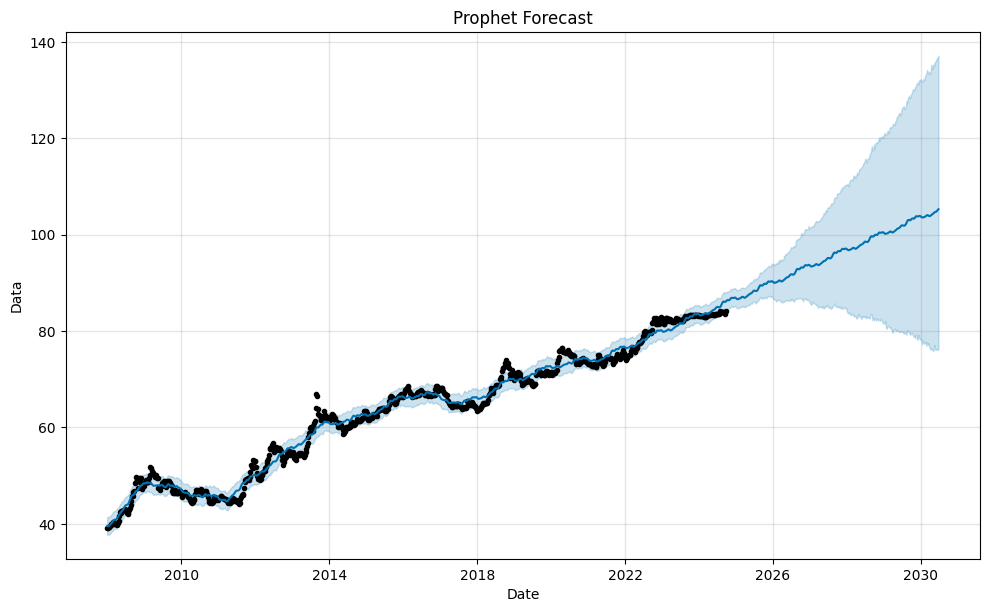

Prophet Model Metrics:
MSE: 2.0767
MAE: 1.1368
RMSE: 1.4411


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet
df_prophet = data_inr[['Data']].reset_index()  # Select only the index and target column
df_prophet.columns = ['ds', 'y']              # Rename columns for Prophet

# Initialize and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Forecast the next 300 days
future = model_prophet.make_future_dataframe(periods=300, freq='W')
forecast_prophet = model_prophet.predict(future)

# Plot the forecast
model_prophet.plot(forecast_prophet)
plt.xlabel("Date")
plt.ylabel("Data")
plt.title("Prophet Forecast")
plt.show()

# Calculate metrics for Prophet model on the historical range
# Ensure alignment between actual and predicted data
prophet_actual = df_prophet['y']
prophet_predicted = forecast_prophet.loc[:len(prophet_actual)-1, 'yhat']

# Compute metrics
mse_prophet = mean_squared_error(prophet_actual, prophet_predicted)
mae_prophet = mean_absolute_error(prophet_actual, prophet_predicted)
rmse_prophet = np.sqrt(mse_prophet)

# Print the results
print(f"Prophet Model Metrics:")
print(f"MSE: {mse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")
print(f"RMSE: {rmse_prophet:.4f}")


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 - 2s - 99ms/step - loss: 0.0539 - val_loss: 6.1556e-04 - learning_rate: 0.0010
Epoch 2/50
22/22 - 1s - 29ms/step - loss: 0.0114 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/50
22/22 - 1s - 28ms/step - loss: 0.0050 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 - 1s - 28ms/step - loss: 0.0051 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 5/50
22/22 - 1s - 30ms/step - loss: 0.0051 - val_loss: 0.0045 - learning_rate: 5.0000e-04
Epoch 6/50
22/22 - 1s - 29ms/step - loss: 0.0041 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Results:
MAE: 0.9288
MSE: 0.9184
RMSE: 0.9583


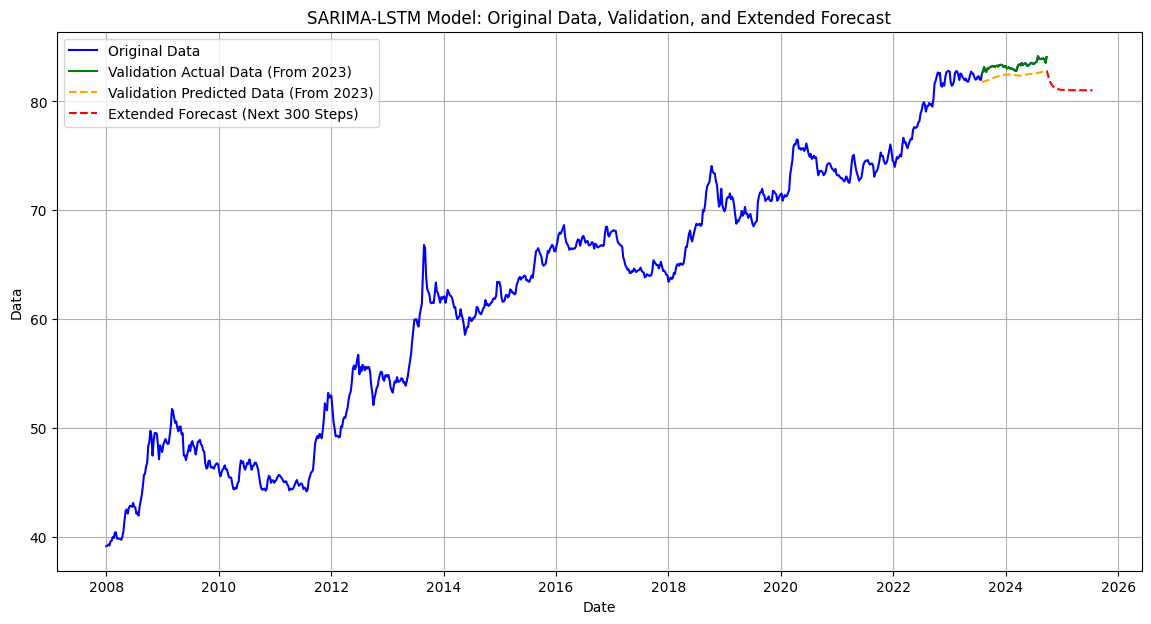

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure the 'Data' column is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Log transform the data to stabilize variance and handle non-linearity
data_inr['Log_Data'] = np.log(data_inr['Data'])

# Filter training and testing data based on the date
train_data = data_inr[data_inr.index < '2023-01-01']
test_data = data_inr[data_inr.index >= '2023-01-01']

# Scale the log-transformed training data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Log_Data']].values)

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' steps)
        y.append(data[i, 0])          # Target (next value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 30
X_train, y_train = create_sequences(scaled_train_data, window)

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dropout(0.3),  # Dropout after the second LSTM layer
    Dense(32, activation='relu'),  # Fully connected dense layer
    Dense(1)  # Output layer (1 value for the next step)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Scale the log-transformed testing data
scaled_test_data = scaler.transform(test_data[['Log_Data']].values)

# Create sequences for the testing data
X_test, y_test = create_sequences(scaled_test_data, window)

# Reshape the testing data for LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict the testing data
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse scale the predictions and actual values
y_test_actual_log = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual_log = scaler.inverse_transform(y_pred_scaled)

# Convert the log-transformed values back to the original scale
y_test_actual = np.exp(y_test_actual_log)
y_pred_actual = np.exp(y_pred_actual_log)

# Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Validation Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Forecast for the next 300 steps
# Use the last 'window' data points as input for forecasting
inputs = scaler.transform(data_inr[['Log_Data']].values[-window:]).reshape((1, window, 1))
forecast_scaled = []

# Generate rolling forecast for 300 steps
for _ in range(300):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next value
    forecast_scaled.append(pred)
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input sequence
    inputs[0, -1, 0] = pred  # Replace the last value in the sequence with the prediction

# Inverse scale the forecasted values back to the original log scale
forecast_log = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Convert the log-transformed forecast back to the original scale
forecast_300 = np.exp(forecast_log)

# Create a forecast index for the next 300 steps
forecast_index_300 = pd.date_range(start=data_inr.index[-1], periods=300, freq="D")

# Plot the original data and the extended forecast
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')

# Plot the validation data (actual vs. predicted)
plt.plot(test_data.index[window:], y_test_actual, label='Validation Actual Data (From 2023)', color='green')
plt.plot(test_data.index[window:], y_pred_actual, label='Validation Predicted Data (From 2023)', linestyle='--', color='orange')

# Create an extended time index that includes the forecast period
extended_index_300 = data_inr.index.append(forecast_index_300)

# Combine original data and forecast for continuous visualization
combined_data_300 = np.concatenate((data_inr['Data'].values, forecast_300.flatten()))

# Plot the extended forecast
plt.plot(forecast_index_300, forecast_300, label='Extended Forecast (Next 300 Steps)', linestyle='--', color='red')

# Add plot details
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('SARIMA-LSTM Model: Original Data, Validation, and Extended Forecast')
plt.legend()
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92499D-01    |proj g|=  5.97106D-01


 This problem is unconstrained.



At iterate    5    f=  7.14483D-01    |proj g|=  1.48260D-01

At iterate   10    f=  6.67184D-01    |proj g|=  4.39759D-02

At iterate   15    f=  6.64410D-01    |proj g|=  3.26608D-02

At iterate   20    f=  6.64119D-01    |proj g|=  4.67741D-03

At iterate   25    f=  6.64107D-01    |proj g|=  3.47333D-03

At iterate   30    f=  6.64088D-01    |proj g|=  1.16629D-03

At iterate   35    f=  6.64087D-01    |proj g|=  1.04184D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     59      1     0     0   4.533D-04   6.641D-01
  F =  0.66408711429630574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 - 1s - 51ms/step - loss: 0.2170 - val_loss: 0.1884 - learning_rate: 0.0010
Epoch 2/100
24/24 - 0s - 5ms/step - loss: 0.1703 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 3/100
24/24 - 0s - 5ms/step - loss: 0.1355 - val_loss: 0.1194 - learning_rate: 0.0010
Epoch 4/100
24/24 - 0s - 5ms/step - loss: 0.1074 - val_loss: 0.0944 - learning_rate: 0.0010
Epoch 5/100
24/24 - 0s - 6ms/step - loss: 0.0848 - val_loss: 0.0743 - learning_rate: 0.0010
Epoch 6/100
24/24 - 0s - 6ms/step - loss: 0.0666 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 7/100
24/24 - 0s - 6ms/step - loss: 0.0521 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 8/100
24/24 - 0s - 6ms/step - loss: 0.0405 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 9/100
24/24 - 0s - 6ms/step - loss: 0.0314 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 10/100
24/24 - 0s - 6ms/step - loss: 0.0241 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 11/100
24/24 - 0s - 6ms/step - loss: 0.0185 - val_loss: 0.0159 - learning_rate: 0.00

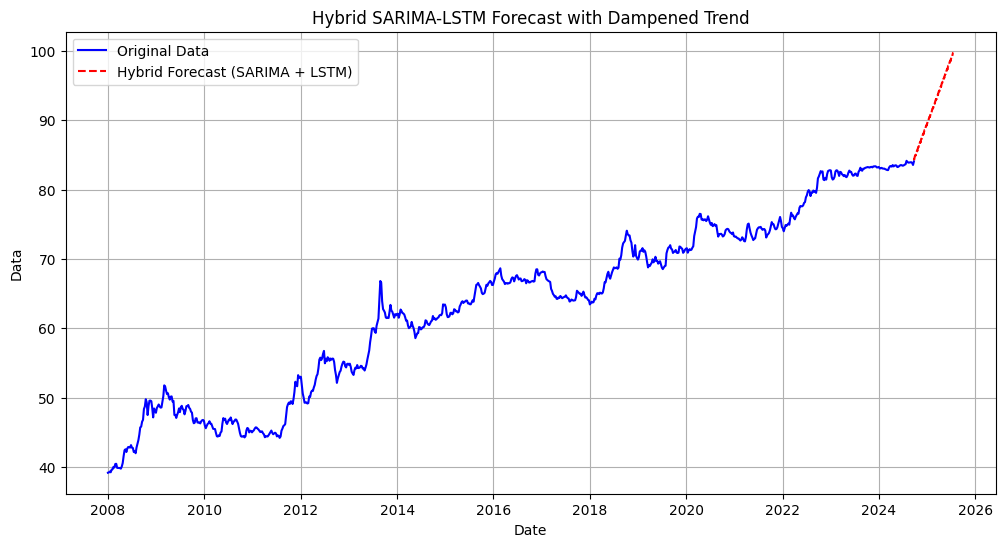

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the 'Data' column in the data is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Fit SARIMA model for trend/seasonality
sarima_model = SARIMAX(data_inr['Data'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Predict trend/seasonality
data_inr['Trend_Seasonality'] = sarima_fit.fittedvalues
data_inr['Residual'] = data_inr['Data'] - data_inr['Trend_Seasonality']

# Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))  # A tighter range to prevent large outputs
scaled_residuals = scaler.fit_transform(data_inr[['Residual']].dropna())

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' residuals)
        y.append(data[i, 0])          # Target (next residual value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 30
X, y = create_sequences(scaled_residuals, window)

# Split data into train and test sets (90% for training, 10% for testing)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model with reduced complexity
model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], 1), kernel_regularizer='l2'),  # Single LSTM layer
    Dropout(0.3),  # Moderate dropout
    Dense(16, activation='relu', kernel_regularizer='l2'),  # Smaller dense layer
    Dense(1)  # Output layer (1 value for the next residual)
])

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)  # Lower min_lr

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs to ensure convergence at a lower learning rate
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Forecast residuals for the next 300 time steps with a rolling window approach
inputs = scaled_residuals[-window:].reshape((1, window, 1))  # Use last 'window' residuals as input
forecast_residuals_scaled = []

# Generate rolling forecast for 300 time steps
for _ in range(300):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next residual
    forecast_residuals_scaled.append(pred)
    # Limit the impact of predictions by dampening them slightly (to smooth the trend)
    pred = pred * 0.8  # Applying a dampening factor to reduce steep changes
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input array to append the prediction
    inputs[0, -1, 0] = pred  # Replace the last value in the input sequence with the adjusted predicted value

# Inverse scale the forecasted residuals back to the original scale
forecast_residuals = scaler.inverse_transform(np.array(forecast_residuals_scaled).reshape(-1, 1))

# Add the trend/seasonality forecast from the SARIMA model
forecast_trend = sarima_fit.get_forecast(steps=300).predicted_mean.values
forecast_final = forecast_trend + forecast_residuals.flatten()  # Combine the trend and residual forecasts

# Create a forecast index (for the next 300 time steps)
forecast_index = pd.date_range(start=data_inr.index[-1], periods=300, freq="D")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')  # Original data
plt.plot(forecast_index, forecast_final, label='Hybrid Forecast (SARIMA + LSTM)', linestyle='--', color='red')  # Forecast
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Hybrid SARIMA-LSTM Forecast with Dampened Trend')
plt.legend()
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1144.046, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1205.289, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1141.776, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1141.263, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1205.289, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1139.280, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1141.262, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1142.951, Time=1.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1140.360, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1140.528, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1139.791, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1142.331, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1139.280, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 5.816 seconds
Optimal 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


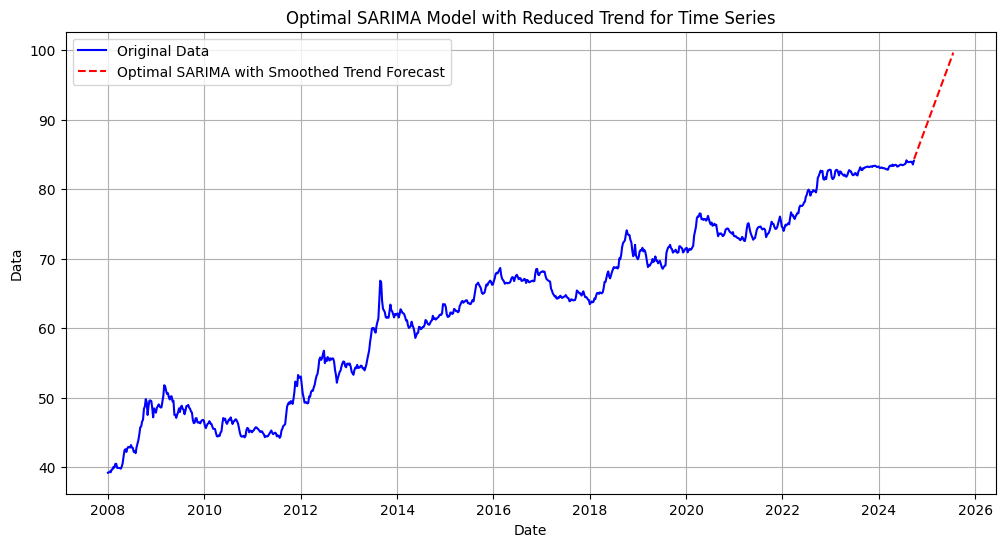

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Ensure that the 'Data' column in the data is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Find the optimal SARIMA model parameters using auto_arima without a strong linear trend
auto_model = auto_arima(
    data_inr['Data'],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=None,  # Let the function determine the order of differencing
    start_P=1, start_Q=1,
    max_P=3, max_Q=3,
    D=None,  # Let the function determine the seasonal differencing
    m=12,  # Assuming monthly seasonality
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    n_jobs=-1,
    trend='c'  # Use a constant trend term to reduce overestimation of the trend
)

# Extract the best model parameters
order = auto_model.order
seasonal_order = auto_model.seasonal_order
trend = auto_model.trend
print(f"Optimal SARIMA order: {order}")
print(f"Optimal seasonal order: {seasonal_order}")
print(f"Optimal trend component: {trend}")

# Fit the SARIMA model using the optimal parameters with a reduced trend emphasis
sarima_model = SARIMAX(data_inr['Data'], order=order, seasonal_order=seasonal_order, trend=trend)
sarima_fit = sarima_model.fit()

# Forecast for the next 300 time steps using the SARIMA model
forecast_steps = 300
forecast_sarima = sarima_fit.get_forecast(steps=forecast_steps).predicted_mean

# Apply an additional smoothing filter to the final forecast to avoid abrupt changes
from scipy.ndimage import gaussian_filter1d
forecast_sarima_smoothed = gaussian_filter1d(forecast_sarima, sigma=2)

# Create a forecast index (for the next 300 time steps)
forecast_index = pd.date_range(start=data_inr.index[-1], periods=forecast_steps + 1, freq="D")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')  # Original data
plt.plot(forecast_index[1:], forecast_sarima_smoothed, label='Optimal SARIMA with Smoothed Trend Forecast', linestyle='--', color='red')  # Forecast
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Optimal SARIMA Model with Reduced Trend for Time Series')
plt.legend()
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48132D-01    |proj g|=  2.70606D-02


 This problem is unconstrained.



At iterate    5    f=  6.47972D-01    |proj g|=  1.72473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   2.860D-05   6.480D-01
  F =  0.64797168523616788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


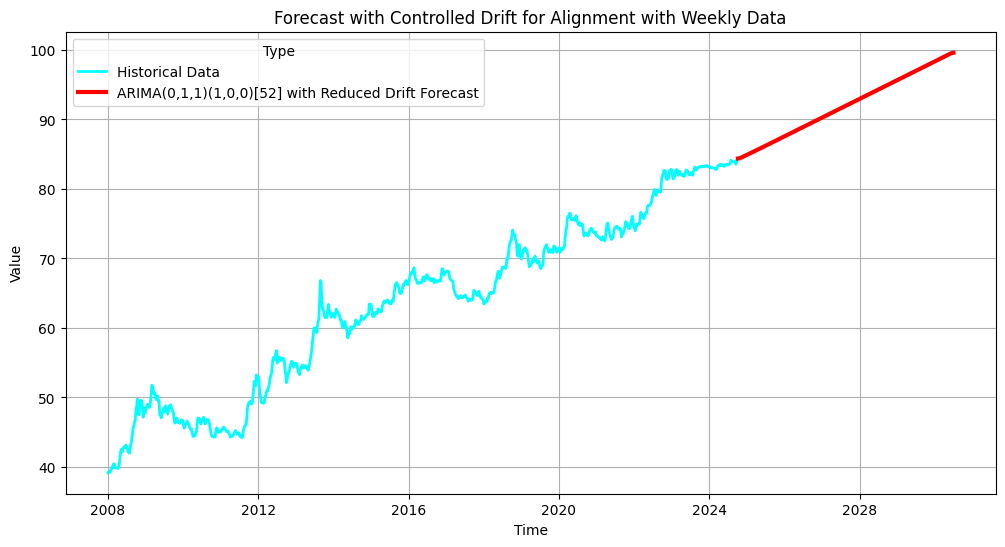

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.ndimage import gaussian_filter1d
import numpy as np

# Ensure that the 'Data' column in the data is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Fit the specified ARIMA model with drift (ARIMA(0,1,1)(1,0,0)[52])
sarima_model = SARIMAX(
    data_inr['Data'],
    order=(0, 1, 1),         # ARIMA(0, 1, 1)
    seasonal_order=(1, 0, 0, 52),  # Seasonal AR(1), no seasonal differencing or MA
    trend='c'                # Use a drift term
)

sarima_fit = sarima_model.fit()

# Forecast for the next 300 weeks using the fitted SARIMA model
forecast_steps = 300
forecast_sarima = sarima_fit.get_forecast(steps=forecast_steps).predicted_mean

# Apply dampening to the forecasted drift to reduce steepness
dampening_factor = 1  # Adjust as necessary to match the R result's slope
forecast_sarima_dampened = forecast_sarima * dampening_factor

# Smooth the forecasted values to further reduce any abrupt changes
forecast_sarima_smoothed = gaussian_filter1d(forecast_sarima_dampened, sigma=3)

# Create a forecast index for the next 300 weeks
forecast_index = pd.date_range(start=data_inr.index[-1], periods=forecast_steps + 1, freq="W")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_inr.index, data_inr['Data'], label='Historical Data', color='cyan', linewidth=2)  # Historical data
plt.plot(forecast_index[1:], forecast_sarima_smoothed, label='ARIMA(0,1,1)(1,0,0)[52] with Reduced Drift Forecast', linestyle='-', color='red', linewidth=3)  # Forecast
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Forecast with Controlled Drift for Alignment with Weekly Data')
plt.legend(title='Type')
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=1143.334, Time=21.22 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1205.289, Time=0.18 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1141.195, Time=5.86 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1140.642, Time=6.77 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1205.289, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1139.280, Time=0.36 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1140.655, Time=6.24 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1142.197, Time=18.27 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1140.360, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=1140.528, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1139.791, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=1142.331, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=1139.280, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[52]          
Total fit time: 59.952 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48522D-01    |proj g|=  3.02041D-02

At iterate    5    f=  6.48330D-01    |proj g|=  1.79706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   3.557D-06   6.483D-01
  F =  0.64832929594630540     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 - 1s - 59ms/step - loss: 0.3076 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 2/100
24/24 - 0s - 5ms/step - loss: 0.1816 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/100
24/24 - 0s - 5ms/step - loss: 0.1476 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 4/100
24/24 - 0s - 5ms/step - loss: 0.1219 - val_loss: 0.1075 - learning_rate: 0.0010
Epoch 5/100
24/24 - 0s - 6ms/step - loss: 0.1003 - val_loss: 0.0887 - learning_rate: 0.0010
Epoch 6/100
24/24 - 0s - 6ms/step - loss: 0.0825 - val_loss: 0.0725 - learning_rate: 0.0010
Epoch 7/100
24/24 - 0s - 6ms/step - loss: 0.0677 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 8/100
24/24 - 0s - 6ms/step - loss: 0.0555 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 9/100
24/24 - 0s - 6ms/step - loss: 0.0456 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 10/100
24/24 - 0s - 6ms/step - loss: 0.0371 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 11/100
24/24 - 0s - 6ms/step - loss: 0.0304 - val_loss: 0.0263 - learning_rate: 0.00

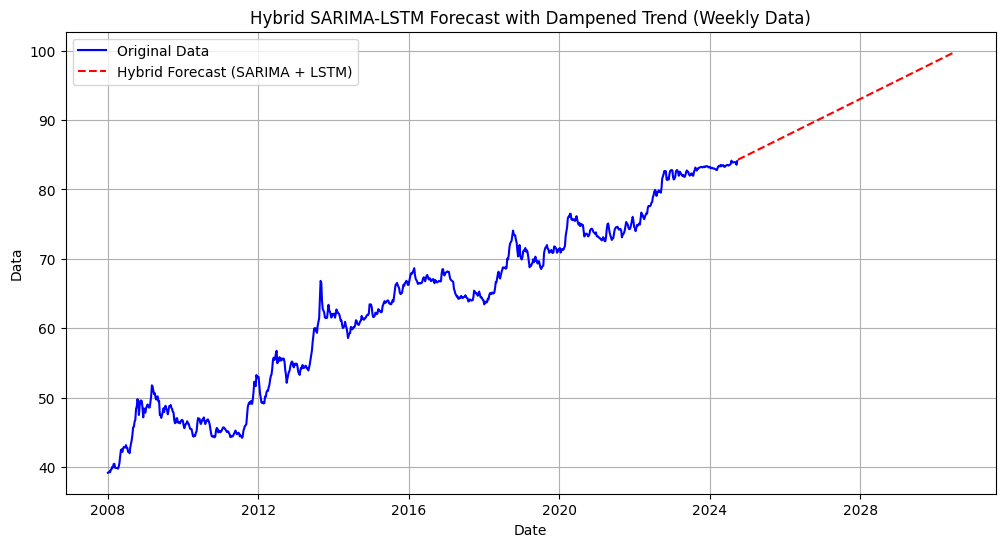

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure that the 'Data' column in the data is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Find the optimal SARIMA model parameters using auto_arima for weekly data
auto_model = auto_arima(
    data_inr['Data'],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=None,  # Let the function determine the order of differencing
    start_P=1, start_Q=1,
    max_P=3, max_Q=3,
    D=None,  # Let the function determine the seasonal differencing
    m=52,  # Assuming weekly data with yearly seasonality (52 weeks per year)
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    n_jobs=-1,
    trend='c'  # Use a constant trend term to reduce overestimation of the trend
)

# Extract the best model parameters
order = auto_model.order
seasonal_order = auto_model.seasonal_order
trend = auto_model.trend

# Fit the SARIMA model using the optimal parameters
sarima_model = SARIMAX(data_inr['Data'], order=order, seasonal_order=seasonal_order, trend=trend)
sarima_fit = sarima_model.fit()

# Predict trend/seasonality
data_inr['Trend_Seasonality'] = sarima_fit.fittedvalues
data_inr['Residual'] = data_inr['Data'] - data_inr['Trend_Seasonality']

# Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))  # A tighter range to prevent large outputs
scaled_residuals = scaler.fit_transform(data_inr[['Residual']].dropna())

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' residuals)
        y.append(data[i, 0])          # Target (next residual value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 30
X, y = create_sequences(scaled_residuals, window)

# Split data into train and test sets (90% for training, 10% for testing)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model with reduced complexity
model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], 1), kernel_regularizer='l2'),  # Single LSTM layer
    Dropout(0.3),  # Moderate dropout
    Dense(16, activation='relu', kernel_regularizer='l2'),  # Smaller dense layer
    Dense(1)  # Output layer (1 value for the next residual)
])

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)  # Lower min_lr

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs to ensure convergence at a lower learning rate
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Forecast residuals for the next 300 weeks with a rolling window approach
inputs = scaled_residuals[-window:].reshape((1, window, 1))  # Use last 'window' residuals as input
forecast_residuals_scaled = []

# Generate rolling forecast for 300 weeks
for _ in range(300):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next residual
    forecast_residuals_scaled.append(pred)
    # Limit the impact of predictions by dampening them slightly (to smooth the trend)
    pred = pred * 0.8  # Applying a dampening factor to reduce steep changes
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input array to append the prediction
    inputs[0, -1, 0] = pred  # Replace the last value in the input sequence with the adjusted predicted value

# Inverse scale the forecasted residuals back to the original scale
forecast_residuals = scaler.inverse_transform(np.array(forecast_residuals_scaled).reshape(-1, 1))

# Add the trend/seasonality forecast from the SARIMA model
forecast_trend = sarima_fit.get_forecast(steps=300).predicted_mean.values
forecast_final = forecast_trend + forecast_residuals.flatten()  # Combine the trend and residual forecasts

# Create a forecast index (for the next 300 weeks)
forecast_index = pd.date_range(start=data_inr.index[-1], periods=300, freq="W")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')  # Original data
plt.plot(forecast_index, forecast_final, label='Hybrid Forecast (SARIMA + LSTM)', linestyle='--', color='red')  # Forecast
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Hybrid SARIMA-LSTM Forecast with Dampened Trend (Weekly Data)')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
import pandas as pd

# Load the existing CSV file into a DataFrame
existing_df = pd.read_csv('forecast.csv')

# Load the original data and prepare it
original_data = data_inr[['Data']].copy()
original_data = original_data.reset_index()  # Reset the index to access the dates
original_data.columns = ['Date', 'INR']  # Rename columns to 'Date' and 'IDR'

# Create a DataFrame for the forecast data
extended_forecast_df = pd.DataFrame({
    'Date': pd.date_range(start=original_data['Date'].iloc[-1] + pd.Timedelta(weeks=1), periods=len(extended_final_forecast), freq='W'),
    'INR': extended_final_forecast
})

# Combine original and forecast data into one DataFrame (keeping only the 'IDR' column)
combined_values = pd.concat([original_data[['INR']], extended_forecast_df[['INR']]], ignore_index=True)

# Add the new combined 'IDR' column to the existing DataFrame
existing_df['INR'] = combined_values

# Save the updated DataFrame back to a CSV file
existing_df.to_csv('forecast.csv', index=False)

# Confirm that the updated data has been saved
print("Combined original and forecasted data added as a new column in the CSV file successfully.")

Combined original and forecasted data added as a new column in the CSV file successfully.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29976D-01    |proj g|=  5.72475D-01

At iterate    5    f=  7.51480D-01    |proj g|=  7.65448D-02

At iterate   10    f=  7.07853D-01    |proj g|=  9.43880D-03

At iterate   15    f=  7.05912D-01    |proj g|=  1.22980D-02

At iterate   20    f=  7.05737D-01    |proj g|=  9.13971D-03

At iterate   25    f=  7.05666D-01    |proj g|=  1.55709D-03

At iterate   30    f=  7.05655D-01    |proj g|=  3.14537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/ym/q8pn40b973g61znsnb_4mfvc0000gn/T/ipykernel_38927/2610418449.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Trend_Seasonality'] = sarima_fit.fittedvalues
/var/folders/ym/q8pn40b973g61znsnb_4mfvc0000gn/T/ipykernel_38927/2610418449.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Trend_Seasonality'] = sarima_fit.get_forecast(steps=len(test_data)).predicted_

Epoch 1/50
22/22 - 2s - 93ms/step - loss: 0.0225 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 2/50
22/22 - 0s - 8ms/step - loss: 0.0024 - val_loss: 4.4707e-04 - learning_rate: 0.0010
Epoch 3/50
22/22 - 0s - 6ms/step - loss: 0.0013 - val_loss: 2.0571e-04 - learning_rate: 0.0010
Epoch 4/50
22/22 - 0s - 6ms/step - loss: 0.0011 - val_loss: 2.6337e-04 - learning_rate: 0.0010
Epoch 5/50
22/22 - 0s - 6ms/step - loss: 0.0010 - val_loss: 1.1389e-04 - learning_rate: 0.0010
Epoch 6/50
22/22 - 0s - 7ms/step - loss: 8.5327e-04 - val_loss: 6.0601e-05 - learning_rate: 0.0010
Epoch 7/50
22/22 - 0s - 7ms/step - loss: 8.3993e-04 - val_loss: 1.0198e-04 - learning_rate: 0.0010
Epoch 8/50
22/22 - 0s - 6ms/step - loss: 7.1185e-04 - val_loss: 2.8431e-04 - learning_rate: 0.0010
Epoch 9/50

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 - 0s - 6ms/step - loss: 6.6469e-04 - val_loss: 7.2233e-05 - learning_rate: 0.0010
Epoch 10/50
22/22 - 0s - 6ms/step - loss: 7.4197e-04 - 

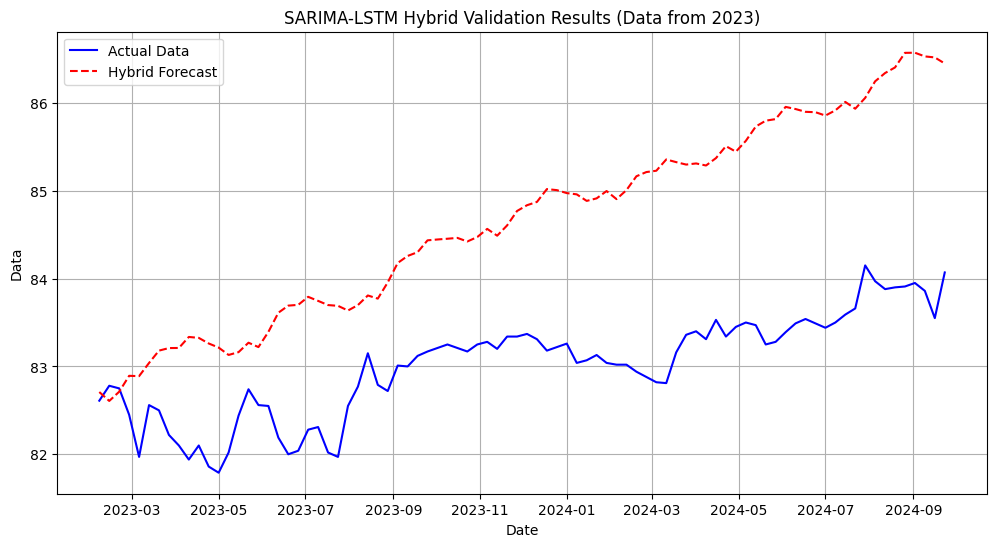

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure the 'Data' column is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Filter training and testing data based on the date
train_data = data_inr[data_inr.index < '2023-01-01']
test_data = data_inr[data_inr.index >= '2023-01-01']

# Fit SARIMA model on the training data
sarima_model = SARIMAX(train_data['Data'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Predict trend/seasonality for training and testing sets
train_data['Trend_Seasonality'] = sarima_fit.fittedvalues
test_data['Trend_Seasonality'] = sarima_fit.get_forecast(steps=len(test_data)).predicted_mean.values

# Compute residuals
train_data['Residual'] = train_data['Data'] - train_data['Trend_Seasonality']
test_data['Residual'] = test_data['Data'] - test_data['Trend_Seasonality']

# Scale the residuals
scaler = MinMaxScaler()
scaled_train_residuals = scaler.fit_transform(train_data[['Residual']].dropna())
scaled_test_residuals = scaler.transform(test_data[['Residual']].dropna())

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' residuals)
        y.append(data[i, 0])          # Target (next residual value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 5
X_train, y_train = create_sequences(scaled_train_residuals, window)
X_test, y_test = create_sequences(scaled_test_residuals, window)

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dropout(0.3),  # Dropout after the second LSTM layer
    Dense(32, activation='relu'),  # Fully connected dense layer
    Dense(1)  # Output layer (1 value for the next step)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train the LSTM model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Forecast residuals for the testing period using the LSTM model
forecast_scaled_residuals = model.predict(X_test, verbose=0)

# Inverse scale the forecasted residuals back to the original scale
forecast_residuals = scaler.inverse_transform(forecast_scaled_residuals)

# Combine SARIMA trend/seasonality forecast with LSTM residual forecast
final_forecast = test_data['Trend_Seasonality'].iloc[window:].values + forecast_residuals.flatten()

# Evaluate the hybrid model's performance
y_test_actual = test_data['Data'].iloc[window:].values
mae = mean_absolute_error(y_test_actual, final_forecast)
mse = mean_squared_error(y_test_actual, final_forecast)
rmse = np.sqrt(mse)

print(f"Validation Results (SARIMA-LSTM Hybrid Model):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[window:], y_test_actual, label='Actual Data', color='blue')
plt.plot(test_data.index[window:], final_forecast, label='Hybrid Forecast', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('SARIMA-LSTM Hybrid Validation Results (Data from 2023)')
plt.legend()
plt.grid(True)
plt.show()


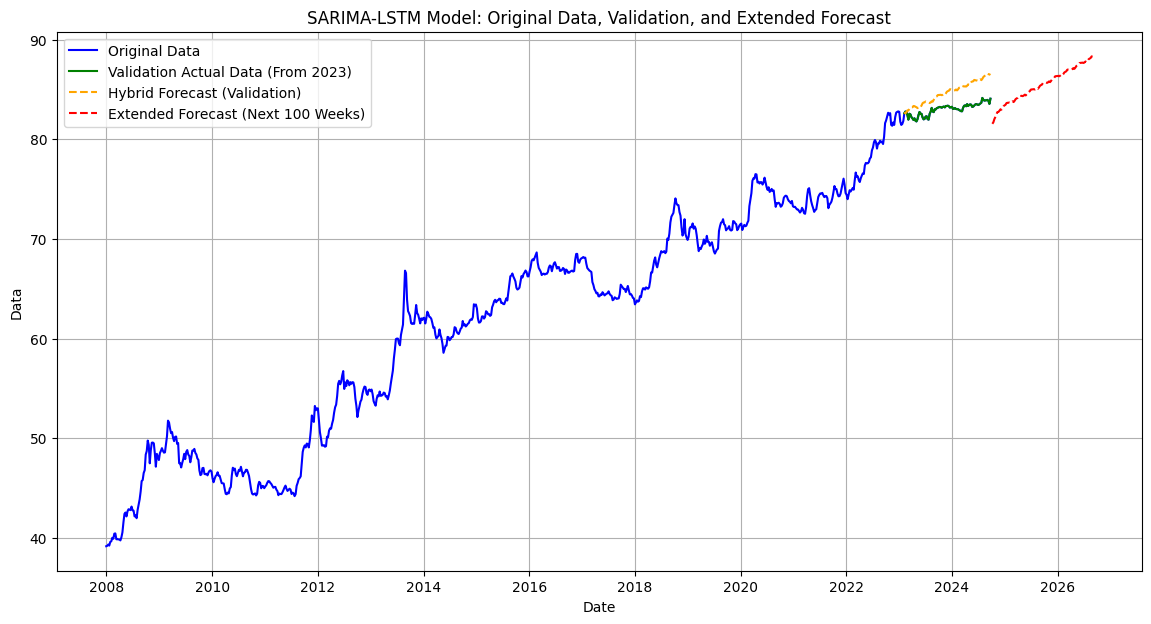

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extend the hybrid model forecast for 100 additional steps beyond the testing period

# Use the last 'window' residuals from the test set as input for forecasting
inputs = scaled_test_residuals[-window:].reshape((1, window, 1))
extended_forecast_scaled_residuals = []

# Generate rolling forecast for the next 100 steps
for _ in range(100):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next residual
    extended_forecast_scaled_residuals.append(pred)
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input sequence
    inputs[0, -1, 0] = pred  # Replace the last value in the sequence with the prediction

# Inverse scale the extended residual forecast back to the original scale
extended_forecast_residuals = scaler.inverse_transform(np.array(extended_forecast_scaled_residuals).reshape(-1, 1))

# Forecast trend/seasonality for the next 100 steps using SARIMA
sarima_extended_trend = sarima_fit.get_forecast(steps=100).predicted_mean.values

# Combine the SARIMA trend/seasonality and LSTM residuals for the final extended forecast
extended_final_forecast = sarima_extended_trend + extended_forecast_residuals.flatten()

# Create a forecast index for the next 100 steps, starting from the end of the test set
forecast_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(weeks=1), periods=100, freq="W")

# Plot the original data, verification data, and extended forecast
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')

# Plot the actual data from the test set
plt.plot(test_data.index[window:], y_test_actual, label='Validation Actual Data (From 2023)', color='green')

# Plot the hybrid model's validation results (SARIMA + LSTM)
plt.plot(test_data.index[window:], final_forecast, label='Hybrid Forecast (Validation)', linestyle='--', color='orange')

# Plot the extended forecast for the next 100 steps without connecting to the hybrid forecast
plt.plot(forecast_index, extended_final_forecast, label='Extended Forecast (Next 100 Weeks)', linestyle='--', color='red')

# Add plot details
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('SARIMA-LSTM Model: Original Data, Validation, and Extended Forecast')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 3s - 127ms/step - loss: 0.0698 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/50
20/20 - 1s - 30ms/step - loss: 0.0117 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/50
20/20 - 1s - 30ms/step - loss: 0.0074 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 4/50
20/20 - 1s - 30ms/step - loss: 0.0062 - val_loss: 5.1797e-04 - learning_rate: 0.0010
Epoch 5/50
20/20 - 1s - 30ms/step - loss: 0.0060 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 6/50
20/20 - 1s - 32ms/step - loss: 0.0051 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 - 1s - 32ms/step - loss: 0.0050 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/50
20/20 - 1s - 33ms/step - loss: 0.0046 - val_loss: 0.0070 - learning_rate: 5.0000e-04
Epoch 9/50
20/20 - 1s - 33ms/step - loss: 0.0045 - val_loss: 0.0076 - learning_rate: 5.0000e-04
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
Validation

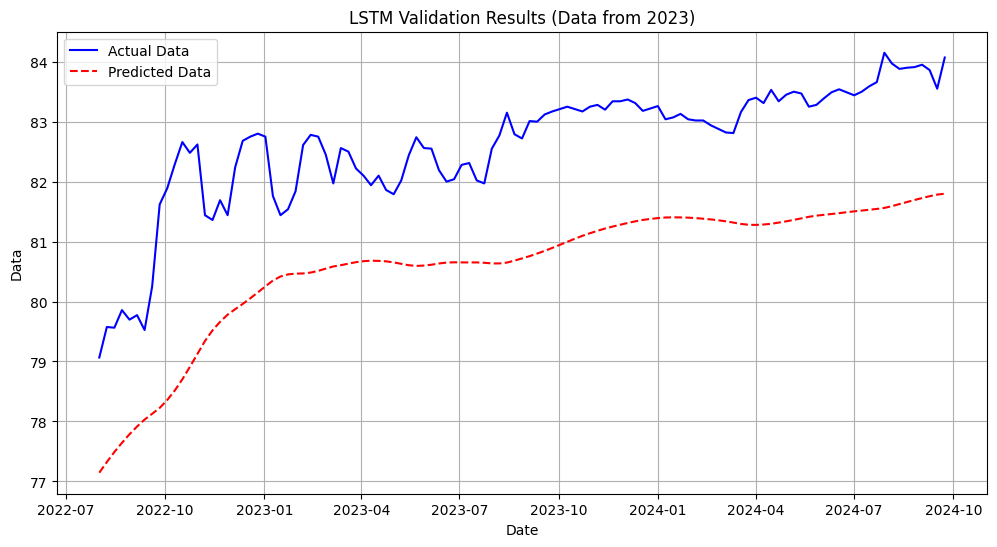

In [12]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure the 'Data' column is numeric and handle missing values
data_inr['Data'] = pd.to_numeric(data_inr['Data'], errors='coerce').ffill()

# Filter training and testing data based on the date
train_data = data_inr[data_inr.index < '2022-01-01']
test_data = data_inr[data_inr.index >= '2022-01-01']

# Scale the training data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Data']].values)

# Create sequences for LSTM input
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])  # Input sequence (previous 'window' steps)
        y.append(data[i, 0])          # Target (next value)
    return np.array(X), np.array(y)

# Set window size for LSTM sequences (e.g., 30 time steps)
window = 30
X_train, y_train = create_sequences(scaled_train_data, window)

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    Dropout(0.3),  # Dropout to prevent overfitting
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dropout(0.3),  # Dropout after the second LSTM layer
    Dense(32, activation='relu'),  # Fully connected dense layer
    Dense(1)  # Output layer (1 value for the next step)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Scale the testing data
scaled_test_data = scaler.transform(test_data[['Data']].values)

# Create sequences for the testing data
X_test, y_test = create_sequences(scaled_test_data, window)

# Reshape the testing data for LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict the testing data
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse scale the predictions and actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Validation Results:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[window:], y_test_actual, label='Actual Data', color='blue')
plt.plot(test_data.index[window:], y_pred_actual, label='Predicted Data', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('LSTM Validation Results (Data from 2023)')
plt.legend()
plt.grid(True)
plt.show()


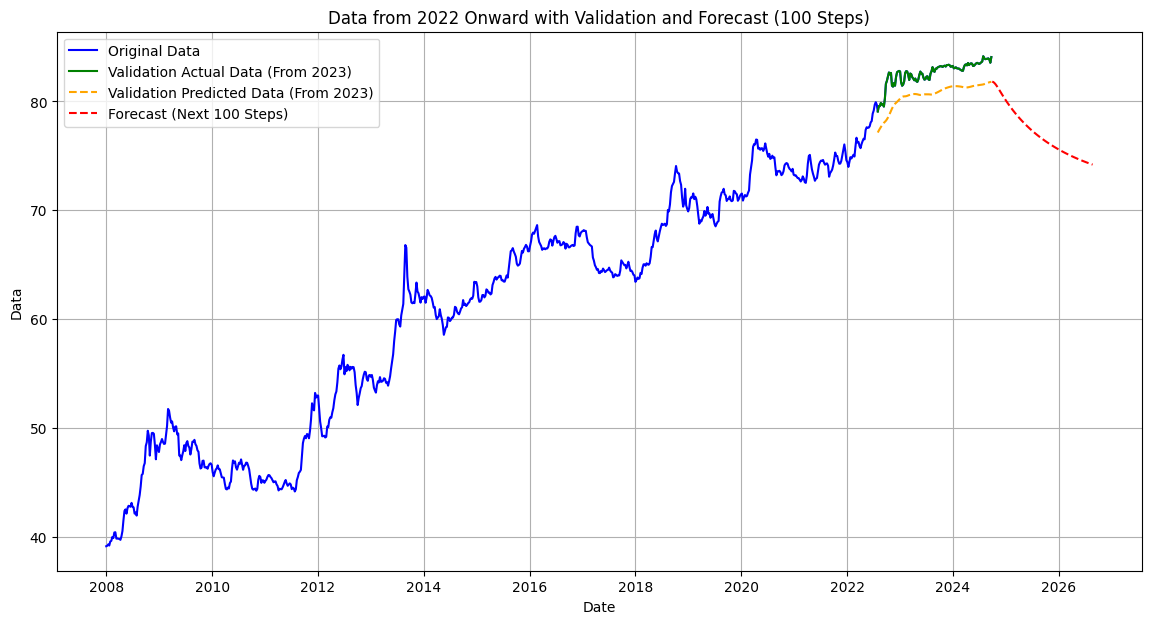

In [13]:
# Forecast for the next 300 steps
# Use the last 'window' data points as input for forecasting
inputs = scaler.transform(data_inr[['Data']].values[-window:]).reshape((1, window, 1))
forecast_scaled = []

# Generate rolling forecast for 300 steps
for _ in range(100):
    pred = model.predict(inputs, verbose=0)[0, 0]  # Predict the next value
    forecast_scaled.append(pred)
    inputs = np.roll(inputs, -1, axis=1)  # Roll the input sequence
    inputs[0, -1, 0] = pred  # Replace the last value in the sequence with the prediction

# Inverse scale the forecasted values back to the original scale
forecast_100 = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create a forecast index for the next 300 steps
forecast_index_100 = pd.date_range(start=data_inr.index[-1], periods=100, freq="W")

# Filter original data to include only data from 2022 onward
data_from_2022 = data_inr[data_inr.index >= '2022-01-01']

# Create a combined dataset for the forecast (next 100 steps)
forecast_index = pd.date_range(start=data_inr.index[-1], periods=100, freq="W")
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Data': forecast_100.flatten()
}).set_index('Date')

# Plot the original data, validation data (actual vs predicted), and forecast
plt.figure(figsize=(14, 7))

# Plot the actual data from 2022 onward
plt.plot(data_inr.index, data_inr['Data'], label='Original Data', color='blue')

# Plot the validation data (actual vs. predicted from 2023 onward)
plt.plot(test_data.index[window:], y_test_actual, label='Validation Actual Data (From 2023)', color='green')
plt.plot(test_data.index[window:], y_pred_actual, label='Validation Predicted Data (From 2023)', linestyle='--', color='orange')

# Plot the forecast for the next 100 steps
plt.plot(forecast_df.index, forecast_df['Forecasted Data'], label='Forecast (Next 100 Steps)', linestyle='--', color='red')

# Add plot details
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Data from 2022 Onward with Validation and Forecast (100 Steps)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
6